In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.optim import AdamW
from torch.utils.data import DataLoader
from dataset.traffic_dataset import TrafficDataset
from utils.Trainer import Trainer
import numpy as np
from models.baselines import GCNMLP, DCRNN, STGCN, MLPBASED
import os
import matplotlib.pyplot as plt
from collections import defaultdict
from dataset.dataset_config import edge_index, edge_attr, week_steps

In [3]:
# MAPE
class MAPELoss(nn.Module):
    """
    안정화를 위해 true 값이 작은 경우 eps로 클램프한 후 계산합니다.
    """
    def __init__(self, eps: float = 1e-3):
        super().__init__()
        self.eps = eps

    def forward(self, pred: torch.Tensor, true: torch.Tensor) -> torch.Tensor:
        # 분모가 너무 작아지는 것을 방지
        denom = torch.clamp(true.abs(), min=self.eps)
        loss = torch.abs((pred - true) / denom)
        return loss.mean()


In [11]:
# 하이퍼파라미터 & 데이터셋 준비
BATCH_SIZE = 32
EPOCHS = 30
LEARNING_RATE = 1e-3
WINDOW = 12                   # 입력 시퀀스 길이
N_PRED = 3                    # 예측 시퀀스 길이
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'

data = np.load('dataset/traffic_dataset_13_smoothen.npy')  # (T_total, E, C_all)
# train/valid split (예: 시계열 뒤쪽 20%를 검증으로)


split_idx = int(data.shape[0] * 0.8)
train_data, valid_data = data[:split_idx], data[split_idx:]

def collate_fn(batch):
    xs = torch.stack([item.x for item in batch], dim=0)
    ys = torch.stack([item.y for item in batch], dim=0)
    return xs, ys

train_ds = TrafficDataset(train_data, window=WINDOW, randomize=True)
valid_ds = TrafficDataset(valid_data, window=WINDOW, randomize=False)
train_loader = DataLoader(train_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)
valid_loader = DataLoader(valid_ds, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_fn)

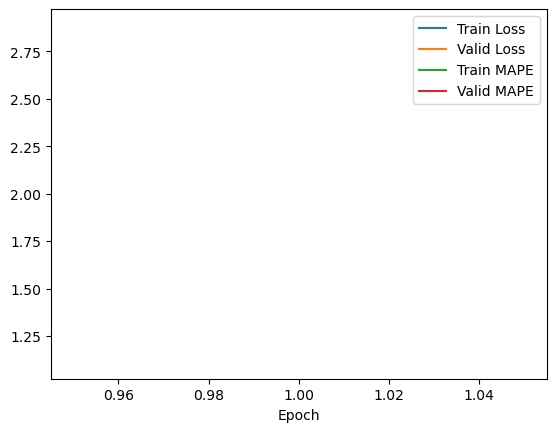

Saved checkpoint: ./checkpoints\MLPBASED.pth


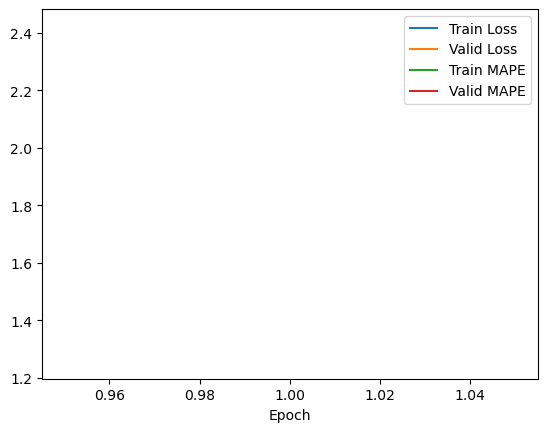

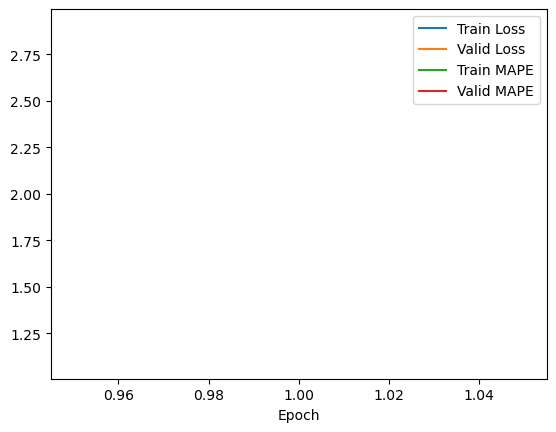

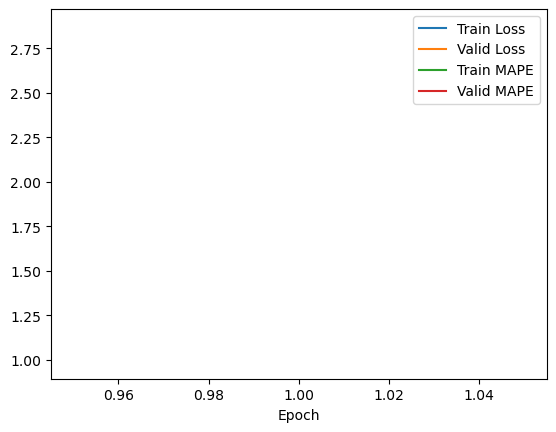

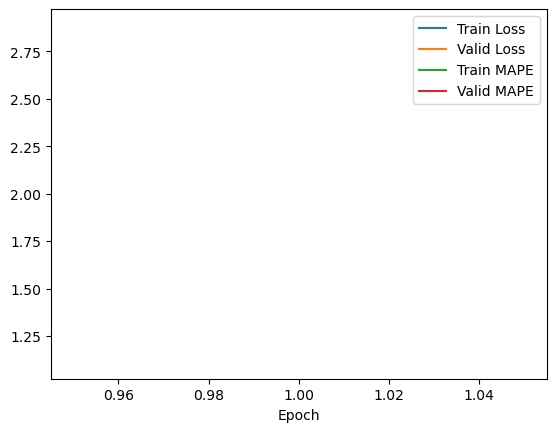

In [ ]:
# Models, Training

# ─────────────────────────────────────────────────────────
# 1) 공통 파라미터 정의
# ─────────────────────────────────────────────────────────
DEVICE       = 'cuda' if torch.cuda.is_available() else 'cpu'
WINDOW       = 12
PRED_OFFSETS = np.array([3, 6, 12])
EDGE_IDS     = [2]                  # 시각화할 edge index 리스트
T_TOTAL      = data.shape[0]        # 전체 타임스텝 수
SAVE_DIR     = "./checkpoints"      
os.makedirs(SAVE_DIR, exist_ok=True)

# ─────────────────────────────────────────────────────────
# 2) 모델 학습 및 가중치 저장
# ─────────────────────────────────────────────────────────
models = {
    "GCNMLP":    GCNMLP,
    "DCRNN":     DCRNN,
    "STGCN":     STGCN,
    "MLPBASED":  MLPBASED,
}

for name, ModelClass in models.items():
    print(f"\n=== Training {name} ===")
    # (1) 배치 데이터에서 차원 정보 추출
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    # (2) 모델 인스턴스화
    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        # GCNMLP, DCRNN, STGCN 공통 생성자 인자
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=256, encoder_depth=3,
            dropout=0.1
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)

        model = ModelClass(**kwargs)

    model = model.to(DEVICE)

    # (3) 옵티마이저·손실함수 설정
    optimizer = AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=1e-5)
    criterion = torch.nn.L1Loss()

    # (4) Trainer 초기화·학습
    trainer = Trainer(
        model=model,
        train_loader=train_loader,
        valid_loader=valid_loader,
        optimizer=optimizer,
        criterion=criterion,
        epochs=1,
        device=DEVICE
    )
    trainer.fit()

    # (5) 가중치 저장
    save_path = os.path.join(SAVE_DIR, f"{name}.pth")
    torch.save(model.state_dict(), save_path)
    print(f"Saved checkpoint: {save_path}")


In [18]:
# ─────────────────────────────────────────────────────────
# 3) 예측·시각화 함수 정의
# ─────────────────────────────────────────────────────────
import numpy as np
from dataset.dataset_config import week_steps

def add_tod_dow(raw_data: np.ndarray, week_steps: int = week_steps) -> np.ndarray:
    """
    원본 데이터에 시간(tod)·요일(dow) 채널을 추가합니다.

    Args:
        raw_data: np.ndarray, shape (T_total, E, C_orig)
            - T_total: 전체 타임스텝 수
            - E: 엣지(센서) 수
            - C_orig: 원래 피처 채널 수 (예: volume, density, flow)
        week_steps: int, default=480*7
            - 주 단위 전체 스텝 수 (예: 7일간 1시간당 1스텝으로 480스텝을 가정)

    Returns:
        np.ndarray, shape (T_total, E, C_orig + 2)
        - 마지막 두 채널이 각각 tod(0~24 float), dow(0~6 int→float) 특성입니다.
    """
    T_total, E, C_orig = raw_data.shape
    day_steps = week_steps // 7

    # 1) 모든 타임스텝 인덱스 생성
    timesteps = np.arange(T_total)

    # 2) 시간대 특성 (0~24)
    tod = (timesteps % day_steps) * (24.0 / day_steps)
    # 3) 요일 특성 (0~6)
    dow = (timesteps // day_steps) % 7

    # 4) (T,1,1) → (T,E,1)로 확장
    tod_feat = np.tile(tod[:, None, None], (1, E, 1)).astype(np.float32)
    dow_feat = np.tile(dow[:, None, None], (1, E, 1)).astype(np.float32)

    # 5) 원본 + tod + dow 순으로 concatenate
    return np.concatenate([raw_data, tod_feat, dow_feat], axis=-1)


def visualize_predictions(model, data, edge_ids, pred_offsets, window, device, edge_index, edge_attr):
    """
    모델(model)을 이용해 data 전체에 대해 sliding-window 예측을 수행하고,
    edge_ids에 해당하는 실제 vs. 예측 시계열을 matplotlib으로 플롯합니다.
    """
    model.eval()
    T_total, E, C_all = data.shape

    # 예측값 임시 저장 구조
    pred_lists = {e: defaultdict(list) for e in edge_ids}

    with torch.no_grad():
        for t0 in range(window - 1, T_total - int(pred_offsets.max())):
            x_win = data[t0 - window + 1:t0 + 1, :, :]
            x_tensor = torch.from_numpy(x_win[None]).float().to(device)  # [1, T, E, C_in]
            
            preds = model(x_tensor, edge_index, edge_attr)              # [1, n_pred, E, C_out]
            preds = preds.cpu().numpy()[0]                              # [n_pred, E, C_out]

            for i, offset in enumerate(pred_offsets):
                t_pred = t0 + offset
                if t_pred >= T_total:
                    continue
                for e in edge_ids:
                    # 예: 채널0(volume)만 시각화
                    pred_lists[e][t_pred].append(preds[i, e, 0])

    # 평균값으로 시계열 복원
    for e in edge_ids:
        pred_series = np.full(T_total, np.nan, dtype=float)
        for t, vals in pred_lists[e].items():
            pred_series[t] = np.mean(vals)
        actual_series = data[:T_total, e, 0]  # 채널0 실제값

        # 플롯
        plt.figure(figsize=(10, 4))
        plt.plot(np.arange(T_total), actual_series,    label=f'Actual Edge {e}')
        plt.plot(np.arange(T_total), pred_series, '--', label=f'Predicted Edge {e}')
        plt.xlabel('Time Step')
        plt.ylabel('Volume Channel')
        plt.title(f'Edge {e}: Actual vs. Predicted')
        plt.legend()
        plt.tight_layout()
        plt.show()




C:\Users\gauoo\AppData\Local\Temp\ipykernel_52780\833415421.py:40: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(ckpt_path, map_location=DEV


--- Visualizing GCNMLP ---


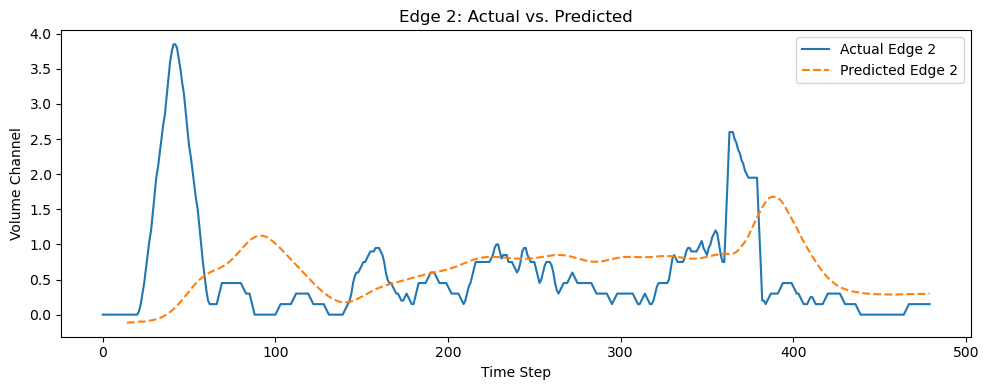


--- Visualizing DCRNN ---


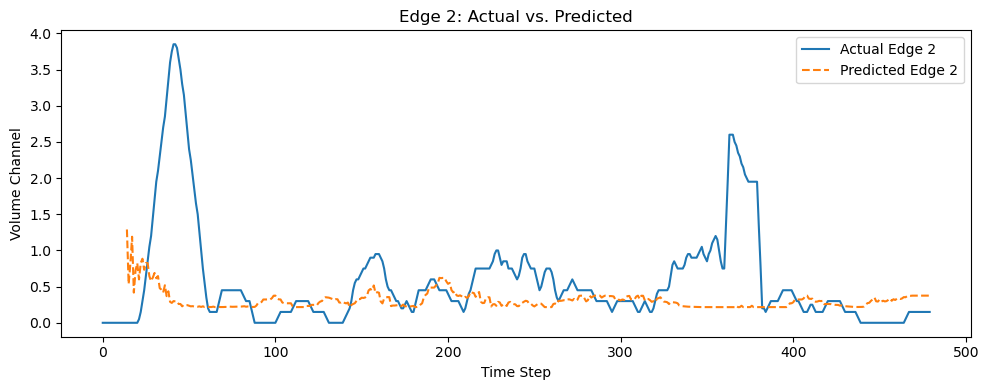


--- Visualizing STGCN ---


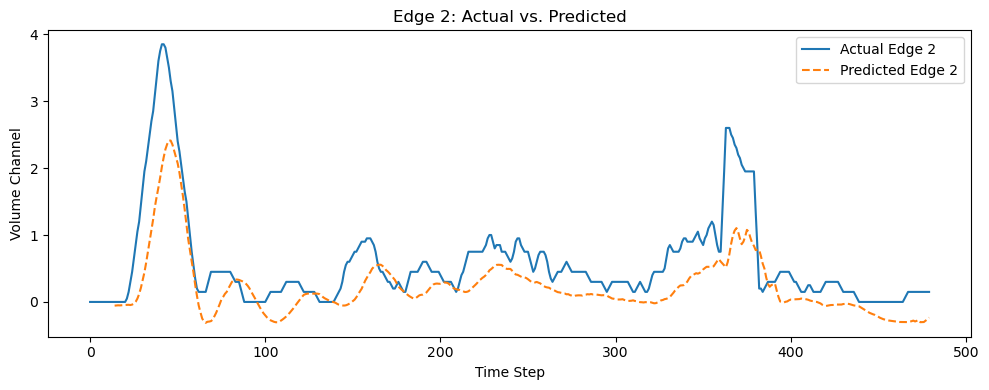


--- Visualizing MLPBASED ---


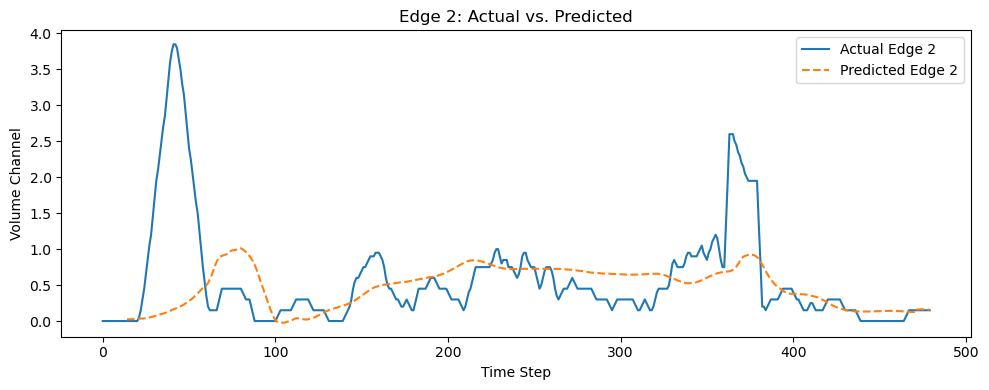

In [19]:
from dataset.traffic_dataset import EDGE_INDEX, EDGE_ATTR
EDGE_INDEX = EDGE_INDEX.to(DEVICE)
EDGE_ATTR = EDGE_ATTR.to(DEVICE)
visualizing_steps = 480

# ─────────────────────────────────────────────────────────
# 4) 저장된 체크포인트 로드 후 일괄 시각화
# ─────────────────────────────────────────────────────────
expended_data = add_tod_dow(data)
expended_data = expended_data[:480]

for name, ModelClass in models.items():
    # (1) 모델 재생성 (학습 시와 동일한 인자 사용)
    #    -- 이하 2)~3)은 학습 루프와 동일하게 구성합니다.
    x_sample, y_sample = next(iter(train_loader))
    _, T, E, D_in = x_sample.shape
    _, _, _, D_out = y_sample.shape
    n_pred = y_sample.size(1)

    if name == "MLPBASED":
        model = ModelClass(T=T, E=E, D_in=D_in, n_pred=n_pred, D_out=D_out,
                           hidden_dim=256, dropout=0.1)
    else:
        kwargs = dict(
            num_nodes=E, node_feature_dim=D_in,
            pred_node_dim=D_out, n_pred=n_pred,
            encoder_embed_dim=32, encoder_depth=1,
            dropout=0.0
        )
        if name == "DCRNN":
            kwargs.update(K=2)
        elif name == "STGCN":
            kwargs.update(kernel_size=3, K=2)
        elif name == "GCNMLP":
            kwargs.update(mlp_hidden_dim=16, mlp_pred_dropout=0.0)
        model = ModelClass(**kwargs)

    # (2) 가중치 로드
    ckpt_path = os.path.join(SAVE_DIR, f"{name}.pth")
    model.load_state_dict(torch.load(ckpt_path, map_location=DEVICE))
    model = model.to(DEVICE)

    print(f"\n--- Visualizing {name} ---")
    visualize_predictions(model, expended_data, EDGE_IDS, PRED_OFFSETS, WINDOW, DEVICE, EDGE_INDEX, EDGE_ATTR)
